<a href="https://colab.research.google.com/github/otausendschoen/Image_Classification_Diffusion-Augmentation/blob/main/02_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Import libraries
!pip install datasets
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

# Loading the Dataset

In [3]:
# REMOVE any old copy
!rm -rf /content/EuroSAT

# COPY cleanly
!cp -r /content/drive/MyDrive/data/eurosat-dataset/6/EuroSAT /content/

In [4]:
dataset = load_dataset(
    "imagefolder",
    data_dir="/content/EuroSAT",
)

print(dataset)

Resolving data files:   0%|          | 0/18099 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 18099
    })
})


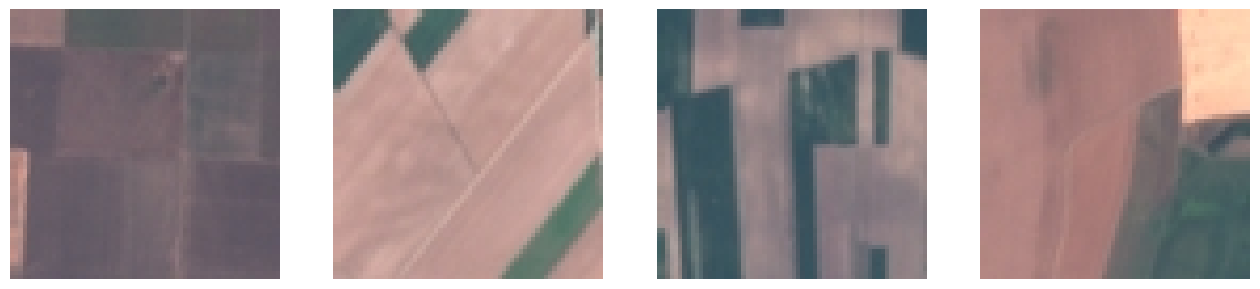

In [5]:
# Visualize some examples
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
plt.show()

Images were preprocessed using a standard pipeline for transfer learning with ImageNet-pretrained models. First, the EuroSAT images were resized from their native 64×64 resolution to 224×224 pixels to match the input requirements of the Wide ResNet50 architecture. The pixel values were then converted to tensors and normalized using ImageNet's channel-wise mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225) to ensure compatibility with the pretrained weights. This preprocessing approach is critical when leveraging transfer learning, as it aligns the input distribution with what the pretrained network expects, allowing effective feature extraction from the early convolutional layers despite the domain shift between natural images and satellite imagery.

In [6]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                                              #Standard input size for Wide ResNet
    transforms.ToTensor(),                                                      #Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #These are the channel-wise means and std of the ImageNet dataset (RGB channels).
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create train-validation split
from sklearn.model_selection import train_test_split

train_val_dataset = dataset["train"]
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,
    stratify=[item['label'] for item in train_val_dataset],
    random_state=8
)

In our implementation, we created a custom EuroSATDataset class that inherits from PyTorch's Dataset, providing an efficient interface between our raw satellite imagery and the training pipeline. This class handles the application of image transformations and maintains the train-validation split through indexing, allowing flexible access to different subsets of the data. We then instantiated separate training and validation datasets with their respective transformations, and wrapped them in DataLoaders with a batch size of 32. The training loader incorporates shuffling to improve model generalization, while the validation loader maintains deterministic ordering. This approach enables efficient batched processing and parallelized data loading, which is essential for training deep convolutional networks like Wide ResNet50 on large image datasets.

In [17]:
# Create PyTorch datasets
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else range(len(dataset))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.dataset[self.indices[idx]]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_train)
val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


For our classification task, we implemented a Wide ResNet50 model through a custom PyTorch class. The WideResNetClassifier leverages transfer learning by initializing with weights pretrained on ImageNet, taking advantage of the general visual features already learned on a vast dataset. The architecture modification occurs at the final fully connected layer, where we replace the original 1000-class output with a 10-class output matching our EuroSAT land cover categories. This approach maintains the powerful feature extraction capabilities of the Wide ResNet50 architecture—with its wider convolutional layers and residual connections—while adapting the classification head specifically for satellite imagery. The forward method simply passes the input through the entire model pipeline, making this implementation both elegant and effective for Earth Observation image classification tasks.

In [18]:
# Define the Wide ResNet50 model
class WideResNetClassifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(WideResNetClassifier, self).__init__()

        # Load pretrained Wide ResNet50
        self.model = models.wide_resnet50_2(pretrained=pretrained)

        # Replacing the final fully connected layer
        in_features = self.model.fc.in_features               # Gets number of features in the final layer
        self.model.fc = nn.Linear(in_features, num_classes)   # Creates new classification layer (10 classes)

    def forward(self, x):
        return self.model(x)

In [22]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = WideResNetClassifier(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()                         #standard choice for multi-class classification problems
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

 # Scheduler implements a cosine annealing learning rate schedule that gradually
 # reduces the learning rate over time. It starts at the optimizer's initial learning
 # rate (1e-4) and decreases following a cosine curve until reaching the minimum value
 # (eta_min=1e-6) after T_max=20 epochs. This helps the model converge to better minima
 # by initially exploring the parameter space with larger steps and then fine-tuning with smaller steps.


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1


Our implementation establishes a comprehensive training framework with integrated early stopping to prevent overfitting on the EuroSAT dataset. The training loop executes up to 30 epochs, with patience set to 5 epochs for early termination if validation accuracy fails to improve. Within each epoch, we conduct a full training pass using our train_one_epoch function, followed by validation with the validate function, while systematically applying learning rate adjustments via the cosine annealing scheduler. Performance metrics including loss, accuracy, and F1-score are tracked for both training and validation sets and stored in a history dictionary for subsequent analysis. We save the model weights only when validation accuracy improves, maintaining the best-performing configuration throughout training.

Epoch 1/30


Training:   0%|          | 0/227 [00:10<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.2446, Train Acc: 0.9300, Train F1: 0.9297
Val Loss: 0.0789, Val Acc: 0.9740, Val F1: 0.9740
Epoch 2/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0756, Train Acc: 0.9756, Train F1: 0.9755
Val Loss: 0.0737, Val Acc: 0.9754, Val F1: 0.9754
Epoch 3/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0418, Train Acc: 0.9883, Train F1: 0.9883
Val Loss: 0.0849, Val Acc: 0.9710, Val F1: 0.9711
Epoch 4/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940> 
 Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers() 
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^^  ^^ ^^  
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  ^Exception ignored in: ^<fun

Train Loss: 0.0366, Train Acc: 0.9886, Train F1: 0.9886
Val Loss: 0.0889, Val Acc: 0.9727, Val F1: 0.9727
Epoch 5/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0283, Train Acc: 0.9910, Train F1: 0.9910
Val Loss: 0.0947, Val Acc: 0.9682, Val F1: 0.9681
Epoch 6/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0211, Train Acc: 0.9930, Train F1: 0.9930
Val Loss: 0.0581, Val Acc: 0.9834, Val F1: 0.9835
Epoch 7/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0150, Train Acc: 0.9956, Train F1: 0.9956
Val Loss: 0.0630, Val Acc: 0.9801, Val F1: 0.9802
Epoch 8/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0082, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0556, Val Acc: 0.9804, Val F1: 0.9803
Epoch 9/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0055, Train Acc: 0.9985, Train F1: 0.9985
Val Loss: 0.0414, Val Acc: 0.9876, Val F1: 0.9876
Epoch 10/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0531, Val Acc: 0.9845, Val F1: 0.9846
Epoch 11/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0067, Train Acc: 0.9979, Train F1: 0.9979
Val Loss: 0.0664, Val Acc: 0.9798, Val F1: 0.9798
Epoch 12/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0460, Val Acc: 0.9881, Val F1: 0.9881
Epoch 13/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0489, Val Acc: 0.9876, Val F1: 0.9876
Epoch 14/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/d

Train Loss: 0.0017, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0507, Val Acc: 0.9845, Val F1: 0.9845
Epoch 15/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940> 
Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive():^
^    ^ ^ ^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ 
  File "/usr/lib/pyt

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0415, Val Acc: 0.9873, Val F1: 0.9873
Epoch 16/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0494, Val Acc: 0.9878, Val F1: 0.9878
Epoch 17/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0454, Val Acc: 0.9884, Val F1: 0.9884
Epoch 18/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0456, Val Acc: 0.9878, Val F1: 0.9878
Epoch 19/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940><function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in 

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0472, Val Acc: 0.9870, Val F1: 0.9870
Epoch 20/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ea88bb2d940>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
      ^ ^  ^ ^^^^^^^^^^^^^^^^^^^^
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self.

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0455, Val Acc: 0.9876, Val F1: 0.9876
Epoch 21/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0449, Val Acc: 0.9873, Val F1: 0.9873
Epoch 22/30


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0469, Val Acc: 0.9876, Val F1: 0.9876
Early stopping at epoch 22


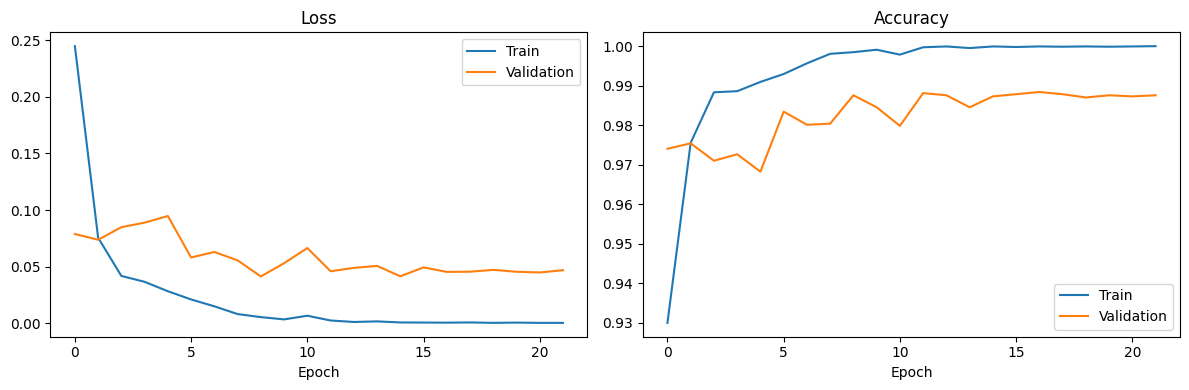

Best validation accuracy: 0.9884


In [21]:
# Training loop with early stopping
num_epochs = 30
patience = 5
best_val_acc = 0
counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_wideresnet.pth')
        counter = 0
    else:
        counter += 1

    # Early stopping
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Print best validation accuracy
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Copy pasted stuff

Loading the Model for Inference
When you want to use the model later, you'll need to:

In [ ]:
# 1. Import necessary libraries
import torch
from torchvision import transforms, models
import torch.nn as nn

# 2. Define the same model architecture
class WideResNetClassifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=False):
        super(WideResNetClassifier, self).__init__()
        self.model = models.wide_resnet50_2(pretrained=pretrained)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# 3. Initialize the model (pretrained=False since we're loading our weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WideResNetClassifier(num_classes=10).to(device)

# 4. Load the saved weights
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_wideresnet.pth'))

# 5. Set the model to evaluation mode
model.eval()

Using the Model for Predictions
Once loaded, you can use it for inference:

In [ ]:
# Define transformation for new images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict a single image
def predict_image(image_path, model, transform, device):
    # Load and transform the image
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# Map class indices to class names
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Example prediction
image_path = "path/to/new/image.jpg"
class_idx = predict_image(image_path, model, transform, device)
print(f"Predicted class: {class_names[class_idx]}")